# Shakespeare Text Generation RNN

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on GitHub
> - ▶️ Demo: [try this model in action](https://trekhleb.github.io/machine-learning-experiments)

## Experiment overview

In this experiment we will use character-based RNN to generate a Shakespeare's-like text based on the Shakespeare dataset from [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) blog post.

_Inspired by [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)_

## Import dependencies

In [0]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

In [72]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.6.9
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Download the dataset

In [73]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

/tmp/.keras/datasets/shakespeare.txt


## Analyze the dataset

In [74]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [75]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [76]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [77]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
  print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [78]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [79]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


## Create training sequences

In [80]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [81]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
  print(index2char[char.numpy()])

F
i
r
s
t


In [82]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
  print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [0]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

In [84]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 11043


In [85]:
for input_example, target_example in dataset.take(1):
  print('Input sequence size:', repr(len(input_example.numpy())))
  print('Target sequence size:', repr(len(target_example.numpy())))
  print()
  print('Input:', repr(''.join(index2char[input_example.numpy()])))
  print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. 

In [86]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
  print('Step {:2d}'.format(i))
  print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
  print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [87]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [88]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 172


## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU): A type of RNN with size units=rnn_units (You can also use a LSTM layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [90]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[8 8 9 0 2 4 4 3]
 [0 6 8 0 8 1 2 8]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.03781053 -0.03447229  0.03491661 -0.02994869  0.00013622]
  [ 0.03781053 -0.03447229  0.03491661 -0.02994869  0.00013622]
  [ 0.00490909 -0.03863578  0.01159984 -0.01789697  0.00687598]
  [-0.03623724  0.01204181  0.03188298 -0.04022557  0.0205582 ]
  [-0.02259059 -0.01879078  0.04708524  0.04786749  0.00748362]
  [-0.04597411 -0.0472619  -0.0226198  -0.00017004  0.02769209]
  [-0.04597411 -0.0472619  -0.0226198  -0.00017004  0.02769209]
  [-0.03819469 -0.04600065  0.04359089  0.01306069  0.00864368]]

 [[-0.03623724  0.01204181  0.03188298 -0.04022557  0.0205582 ]
  [ 0.03317112  0.01137064 -0.04696338 -0.04302     0.016711  ]
  [ 0.03781053 -0.03447229  0.03491661 -0.02994869  0.00013622]
  [-0.03623724  0.01204181  0.03188298 -0.04022557  0.0205582 ]
  [ 0.03781053 -0.03447229  0.03491661 -0.02994869  0.00013622]
  [-0.03816844  0.03338661 

In [0]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
  ))

  model.add(tf.keras.layers.GRU(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
  ))

  model.add(tf.keras.layers.Dense(vocab_size))
  
  return model

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [94]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (64, None, 256)           16640     
_________________________________________________________________
gru_2 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
dense_2 (Dense)              (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


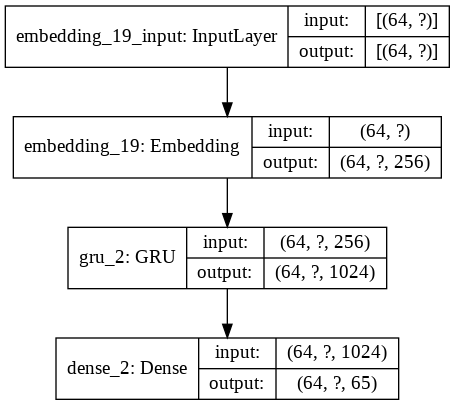

In [95]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Model architecture](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

## Try the model

In [0]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [0]:
  print('Prediction for the 1st letter of the 1st sequense:')
  print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the 1st sequense:
tf.Tensor(
[ 3.1966227e-03 -8.8526774e-03 -3.4674974e-03  1.6182883e-02
  9.3540847e-03  4.0862216e-03 -1.5090228e-03  7.4894965e-04
 -7.7760238e-03 -1.0161902e-02  1.7187862e-02  6.3877227e-03
 -4.1217026e-03 -1.3492947e-02 -5.1083608e-04  2.0579719e-03
 -7.7333343e-03  3.5493239e-03  6.5354677e-04  1.3597684e-03
 -4.0064487e-03  8.2383892e-03  5.8827810e-03  2.8995300e-02
 -5.8203400e-03 -1.5802982e-03 -9.5813163e-03  2.8556488e-03
  9.0704476e-03 -2.3325821e-03 -8.7405220e-03  1.0822958e-02
  1.7553385e-03 -3.9938746e-05  1.0548285e-02  6.4805569e-03
  3.7297241e-03 -2.3623228e-04  4.4680261e-03 -2.8032234e-03
 -8.7307934e-03 -7.7203242e-03 -7.1992232e-03  9.0769222e-03
  7.2081154e-03  7.5560207e-03 -1.3503864e-03 -2.5428073e-03
  2.1690070e-03 -1.4647013e-04 -9.7763259e-03 -6.1249454e-03
 -3.4452579e-03  5.7955068e-03  5.3468428e-04  5.1884255e-03
  6.3720359e-03 -2.9836821e-03  8.3098896e-03  4.7376216e-03
 -1.0548888e-03 -9.9418

In [0]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)
sampled_indices.shape

TensorShape([100, 1])

In [0]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()
sampled_indices.shape

(100,)

In [0]:
sampled_indices

array([55, 58, 10, 53,  3, 12, 41, 57,  0, 38,  9,  8, 12,  8, 40, 26, 59,
       16,  6, 55,  8, 61, 12, 48, 56, 18, 19, 47, 46, 59,  4, 38, 63, 13,
       38, 62, 60, 64, 37, 61, 58, 29, 30, 28, 46,  4, 25, 22, 57, 29, 20,
       42, 31, 31, 55, 26, 46,  8,  1, 60, 38, 32,  0, 37, 34, 36, 61, 58,
       57, 48, 16,  3, 54, 32, 23, 32, 49,  2,  6, 47, 44, 39, 31, 17,  8,
       15, 27, 19, 42, 59, 38, 64, 32, 33,  3, 40, 10, 47, 31, 64])

In [0]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 "g suffer'd, rivers cannot quench.\n\nWARWICK:\nIn Warwickshire I have true-hearted friends,\nNot mutinou"

Next char prediction:
 'qt:o$?cs\nZ3.?.bNuD,q.w?jrFGihu&ZyAZxvzYwtQRPh&MJsQHdSSqNh. vZT\nYVXwtsjD$pTKTk!,ifaSE.COGduZzTU$b:iSz'


## Train the model

### Attach an optimizer, and a loss function

In [0]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(
      labels,
      logits,
      from_logits=True
  )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.174522


In [0]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [0]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [0]:
EPOCHS=30

In [0]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Train for 172 steps
Epoch 1/30
172/172 [==============================] - 27s 158ms/step - loss: 2.7198
Epoch 2/30
172/172 [==============================] - 26s 150ms/step - loss: 1.9745
Epoch 3/30
172/172 [==============================] - 26s 150ms/step - loss: 1.7037
Epoch 4/30
172/172 [==============================] - 26s 152ms/step - loss: 1.5515
Epoch 5/30
172/172 [==============================] - 26s 150ms/step - loss: 1.4609
Epoch 6/30
172/172 [==============================] - 26s 150ms/step - loss: 1.3999
Epoch 7/30
172/172 [==============================] - 26s 150ms/step - loss: 1.3530
Epoch 8/30
172/172 [==============================] - 26s 151ms/step - loss: 1.3149
Epoch 9/30
172/172 [==============================] - 26s 151ms/step - loss: 1.2796
Epoch 10/30
172/172 [==============================] - 26s 150ms/step - loss: 1.2474
Epoch 11/30
172/172 [==============================] - 26s 150ms/step - loss: 1.2162
Epoch 12/30
172/172 [==============================] -

In [0]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    # val_loss = training_history.history['val_loss']

    # accuracy = training_history.history['accuracy']
    # val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    # plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    # plt.subplot(1, 2, 2)
    # plt.title('Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.plot(accuracy, label='Training set')
    # # plt.plot(val_accuracy, label='Test set', linestyle='--')
    # plt.legend()
    # plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

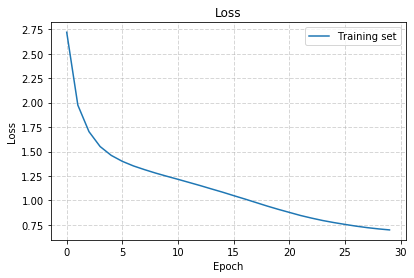

In [0]:
render_training_history(history)

## Generate text

### Restore the latest checkpoint

In [0]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_30'

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_2 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_2 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

In [0]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2index[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(index2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [0]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: though late me quite about? I lay away
From off thee better than I would not let it round
Of all the points; there were I'ld make
No equal time!

SICINIUS:
Nay, but, if the devil he;
His worthy thranged mouths, which now's our jounntie's slage,
Make's gold in love with thunder wholesome flowers.

PRINCE stand him good
uncleaning to me from me; and then you
see, the lodging of the whole throne intenous;
Which is in reverend full time of divine and distressed by
Behind that, nor dead-heavy doom!
My princely siege: it is no more such Sicilian majo-bow! Hence fit to scold.

PRINCE EDWARD:
Now, Warwick, although all the instrument,
Though they have brudel bowes; or sup resign'd my own?

LADY CAPULET:
These giedding: prithee, peace again,
Your liberties
Were liberty.

PROSPERO:
My souls whose five, with men plantur'd tro; I quite o'erpast
That they are many time.

DENCUSTI:
Courage! my master, now; o change not me.
Nay, let me harm; but by profane,
Not the direcution of a dream'd prin

## Save the model

In [0]:
model_name = 'text_generation_rnn.h5'
model.save(model_name, save_format='h5')